In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torchvision.transforms.functional as T
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from pretrain import init, train
from configs import FCConfig, CAEConfig
from src.data.collators import fc_collator

from src.model.FullyConnectedAE import FCAutoencoder
from src.model.ConvolutionalAE import CNNAutoencoder

from src.data.dataset import get_train_dataset, get_val_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setting up some useful functions

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"


def draw_pretrain_plot(train_losses, val_losses, ax):
    x = np.arange(len(train_losses))

    ax.plot(x, train_losses, c="C0", label="train")
    ax.plot(x, val_losses, c="C1", label="val")
    ax.set(title="Pretrain model losses", xlabel="Epoches",
           ylabel="Loss")
    ax.semilogy()

@torch.no_grad()
def construct_grid(model, dataset, num_images=10, ids=None, f=None, collator=None):
    if ids is None:
        ids = np.random.randint(0, len(dataset), size=num_images)
    img_batch = torch.Tensor()
    restored_img_batch = torch.Tensor()
    for idx in ids:
        img, _ = dataset[idx]
        if collator is not None:
            img, _ = collator([(img, _)])
        restored_img = model(img)
        if f is not None:
            img = f(img)
            restored_img = f(restored_img)
        img_batch = torch.cat([img_batch, img.unsqueeze(0)], dim=0)
        restored_img_batch = torch.cat([restored_img_batch,
                                        restored_img.unsqueeze(0)], dim=0)

    img_batch = make_grid((img_batch + 1) / 2, nrow=num_images, padding=1)
    restored_img_batch = make_grid((restored_img_batch + 1) / 2, nrow=num_images, padding=1)
    grid = torch.cat([img_batch, restored_img_batch], dim=1)
    return grid

def show_grid(grid, img_size=(5, 5)):
    fig, axs = plt.subplots(figsize=(5 * img_size[0], 5 * img_size[1]),
                            squeeze=False)
    grid = grid.detach()
    grid = T.to_pil_image(grid)
    # grid = grid.permute(1, 2, 0)
    # grid = (grid + 1) / 2
    axs[0, 0].imshow(grid)
    axs[0, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def pretrain(model, optimizer, criterion, scheduler, train_dataloader,
             val_dataloader, val_dataset, num_epoches, checkpoint_path, f=None, collator=None):
    train_losses = []
    val_losses = []
    fig, ax = plt.subplots(figsize=(12, 9))
    for epoch in range(num_epoches):
        train_loss, val_loss = train(model, optimizer, criterion, scheduler,
                                         train_dataloader, val_dataloader, checkpoint_path,
                                         device=device, num_epoches=1)
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        clear_output()
        draw_pretrain_plot(train_losses, val_losses, ax)
        grid = construct_grid(model, val_dataset, f=f, collator=collator)
        show_grid(grid)
        plt.show()

### Pretraining

#### Fully connected autoencoder

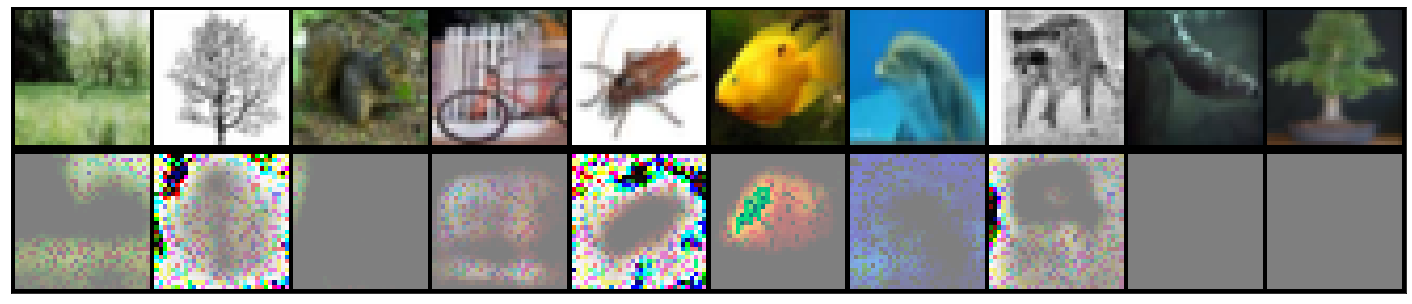

epoch loss: 0.19762097299098969:  13%|█▎        | 52/390 [00:10<01:04,  5.26it/s]

In [ ]:
model, optimizer, criterion, scheduler = init(FCConfig, FCAutoencoder)
train_dataset = get_train_dataset("../data", False)
val_dataset = get_val_dataset("../data", False)
fc_image_reshaper = lambda img: img.view(3, 32, 32)
train_dataloader = DataLoader(train_dataset, FCConfig.train_config.train_batch_size, shuffle=True,
                              num_workers=6, collate_fn=fc_collator, pin_memory=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, FCConfig.train_config.eval_batch_size, shuffle=False,
                            num_workers=6, collate_fn=fc_collator, pin_memory=True)


pretrain(model, optimizer, criterion, scheduler, train_dataloader, val_dataloader, val_dataset, 10,
         FCConfig.train_config.checkpoint_path, fc_image_reshaper, fc_collator)